<a href="https://colab.research.google.com/github/hakmin1015/PowerSystemEconomics/blob/main/etc/AI_LSTM/LSTM_ptemp_max_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Develop 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/LoadForecasting/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/LoadForecasting


Train-validation set 크기: 956
Test set 크기: 1
Epoch 1/50
27/27 [==============================] - 4s 54ms/step - loss: 0.0894 - val_loss: 0.0618
Epoch 2/50
27/27 [==============================] - 1s 23ms/step - loss: 0.0582 - val_loss: 0.0593
Epoch 3/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0538 - val_loss: 0.0634
Epoch 4/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0506 - val_loss: 0.0645
Epoch 5/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0498 - val_loss: 0.0735
Epoch 6/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0478 - val_loss: 0.0793
Epoch 7/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0475 - val_loss: 0.0811
Epoch 8/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0477 - val_loss: 0.0839
Epoch 9/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0470 - val_loss: 0.0704
Epoch 10/50
27/27 [==============================] - 0s 16ms/step

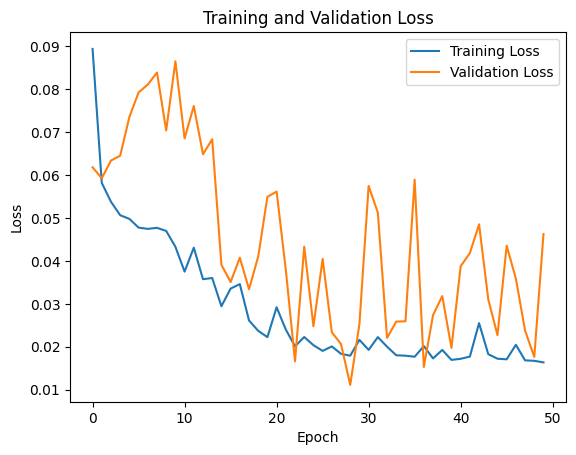

1/1 [==============================] - 0s 462ms/step
예측한 최고 전력 :  889.1084460616112
실제 전력 :  1021
오차율(%) :  -12.91787991561105


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# train과 validation set을 2021년 1월 1일부터 입력된 날짜 기준 이틀 전까지로 설정
input_date = '2023-08-17'
# input_date = input('예측할 날짜를 입력하시오 (YYYY-MM-DD) : ')
input_date = datetime.datetime.strptime(input_date, '%Y-%m-%d')

train_validation_set = df[(df['date'] >= '2021-01-01') & (df['date'] < input_date - datetime.timedelta(days=2))]

# test set은 input_date 하루만
test_set = df[df['date'] == input_date]

# 결과 확인
print("Train-validation set 크기:", len(train_validation_set))
print("Test set 크기:", len(test_set))

# 전체 데이터에서 'p-temp'와 'max' 컬럼만 사용
data = train_validation_set[['p-temp', 'max']].values

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
# print(data_scaled)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], 1)),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 예측 함수
def predict_power_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0] - 2

    # 이전 sequence_length일의 p-temp 값 추출
    X_input = data_scaled[idx-sequence_length:idx, 0]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, 1))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    predicted_power = scaler.inverse_transform([[X_input[0][-1][0], prediction[0][0]]])[0][1]

    return predicted_power

# 예측
predicted_power = predict_power_for_date(input_date, model, scaler, sequence_length)
print("예측한 최고 전력 : ", predicted_power)

# 실제 전력 출력
actual_power = test_set['max'].values[0]
print("실제 전력 : ", actual_power)

# 오차율 출력
error_rate = (predicted_power - actual_power) / actual_power * 100
print("오차율(%) : ", error_rate)

Train-validation set 크기: 956
Test set 크기: 1
Epoch 1/50
27/27 [==============================] - 4s 56ms/step - loss: 0.0885 - val_loss: 0.0676
Epoch 2/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0601 - val_loss: 0.0626
Epoch 3/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0492 - val_loss: 0.0590
Epoch 4/50
27/27 [==============================] - 1s 22ms/step - loss: 0.0421 - val_loss: 0.0541
Epoch 5/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0444 - val_loss: 0.0553
Epoch 6/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0404 - val_loss: 0.0501
Epoch 7/50
27/27 [==============================] - 0s 15ms/step - loss: 0.0381 - val_loss: 0.0671
Epoch 8/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0357 - val_loss: 0.0621
Epoch 9/50
27/27 [==============================] - 0s 14ms/step - loss: 0.0336 - val_loss: 0.0560
Epoch 10/50
27/27 [==============================] - 0s 16ms/step

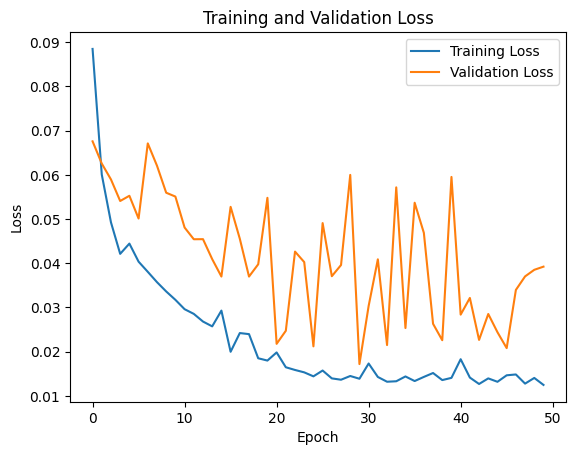

1/1 [==============================] - 0s 408ms/step
예측한 최고 전력 :  959.6385741829871
실제 최고 전력 :  1021
오차율(%) :  -6.009933968365612


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# train과 validation set을 2021년 1월 1일부터 입력된 날짜 기준 이틀 전까지로 설정
input_date = '2023-08-17'
input_date = datetime.datetime.strptime(input_date, '%Y-%m-%d')

train_validation_set = df[(df['date'] >= '2021-01-01') & (df['date'] < input_date - datetime.timedelta(days=2))]

# test set은 input_date 하루만
test_set = df[df['date'] == input_date]

# 결과 확인
print("Train-validation set 크기:", len(train_validation_set))
print("Test set 크기:", len(test_set))

# 전체 데이터에서 'p-temp', 'solar'와 'max' 컬럼만 사용
data = train_validation_set[['p-temp', 'solar', 'max']].values

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 예측 함수
def predict_power_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0] - 2

    # 이전 sequence_length일의 p-temp와 solar 값 추출
    X_input = data_scaled[idx-sequence_length:idx, :-1]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, X_input.shape[1]))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    last_sequence = np.concatenate((X_input[0, -1, :], prediction[0])).reshape(1, -1)
    predicted_power = scaler.inverse_transform(last_sequence)[0, -1]

    return predicted_power

# 예측
predicted_power = predict_power_for_date(input_date, model, scaler, sequence_length)
print("예측한 최고 전력 : ", predicted_power)

# 실제 최고 전력 출력
actual_power = test_set['max'].values[0]
print("실제 최고 전력 : ", actual_power)

# 오차율 출력
error_rate = (predicted_power - actual_power) / actual_power * 100
print("오차율(%) : ", error_rate)


## 피처 스케일링, 모델구조 개선

Train-validation set 크기: 956
Test set 크기: 1
Epoch 1/50
27/27 [==============================] - 8s 66ms/step - loss: 0.0752 - val_loss: 0.0576
Epoch 2/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0548 - val_loss: 0.0593
Epoch 3/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0459 - val_loss: 0.0529
Epoch 4/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0415 - val_loss: 0.0599
Epoch 5/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0391 - val_loss: 0.0557
Epoch 6/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0337 - val_loss: 0.0511
Epoch 7/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0357 - val_loss: 0.0609
Epoch 8/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0322 - val_loss: 0.0384
Epoch 9/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0323 - val_loss: 0.0485
Epoch 10/50
27/27 [==============================] - 1s 43ms/step

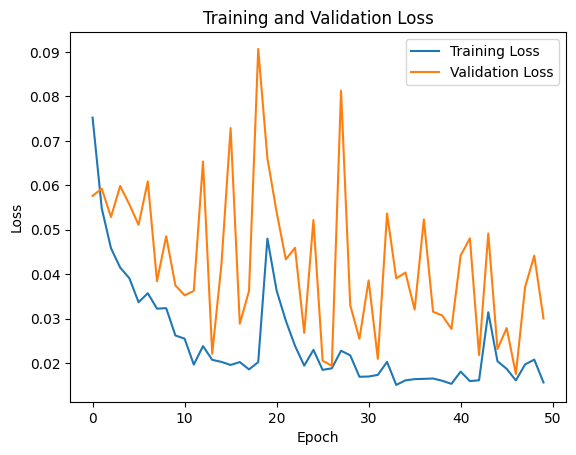

1/1 [==============================] - 1s 804ms/step
예측한 최고 전력 :  960.844786286354
실제 최고 전력 :  1021
오차율(%) :  -5.891793703589231


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# train과 validation set을 2021년 1월 1일부터 입력된 날짜 기준 이틀 전까지로 설정
input_date = '2023-08-17'
input_date = datetime.datetime.strptime(input_date, '%Y-%m-%d')

train_validation_set = df[(df['date'] >= '2021-01-01') & (df['date'] < input_date - datetime.timedelta(days=2))]

# test set은 input_date 하루만
test_set = df[df['date'] == input_date]

# 결과 확인
print("Train-validation set 크기:", len(train_validation_set))
print("Test set 크기:", len(test_set))

# 전체 데이터에서 'p-temp', 'solar'와 'max' 컬럼만 사용
data = train_validation_set[['p-temp', 'solar', 'max']].values

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# LSTM 모델 정의
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X, y, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 예측 함수
def predict_power_for_date(date, model, scaler, sequence_length):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0] - 2

    # 이전 sequence_length일의 p-temp와 solar 값 추출
    X_input = data_scaled[idx-sequence_length:idx, :-1]

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input = X_input.reshape((1, sequence_length, X_input.shape[1]))

    # 예측
    prediction = model.predict(X_input)

    # 스케일링된 예측값을 디스케일링
    last_sequence = np.concatenate((X_input[0, -1, :], prediction[0])).reshape(1, -1)
    predicted_power = scaler.inverse_transform(last_sequence)[0, -1]

    return predicted_power

# 예측
predicted_power = predict_power_for_date(input_date, model, scaler, sequence_length)
print("예측한 최고 전력 : ", predicted_power)

# 실제 최고 전력 출력
actual_power = test_set['max'].values[0]
print("실제 최고 전력 : ", actual_power)

# 오차율 출력
error_rate = (predicted_power - actual_power) / actual_power * 100
print("오차율(%) : ", error_rate)


## 외생변수 가중치 적용

Train-validation set 크기: 956
Test set 크기: 1
Epoch 1/50
27/27 [==============================] - 6s 67ms/step - loss: 0.0740 - val_loss: 0.0565
Epoch 2/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0537 - val_loss: 0.0649
Epoch 3/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0500 - val_loss: 0.0684
Epoch 4/50
27/27 [==============================] - 1s 32ms/step - loss: 0.0458 - val_loss: 0.0886
Epoch 5/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0457 - val_loss: 0.0597
Epoch 6/50
27/27 [==============================] - 1s 45ms/step - loss: 0.0416 - val_loss: 0.0984
Epoch 7/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0423 - val_loss: 0.0646
Epoch 8/50
27/27 [==============================] - 1s 54ms/step - loss: 0.0369 - val_loss: 0.0745
Epoch 9/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0357 - val_loss: 0.0538
Epoch 10/50
27/27 [==============================] - 1s 29ms/step

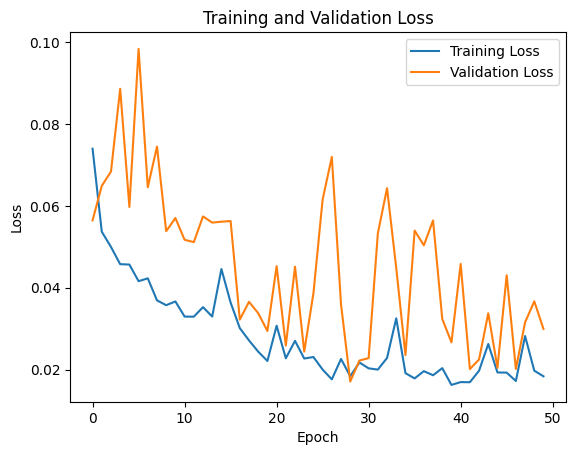

1/1 [==============================] - 1s 1s/step
예측한 최고 전력 :  936.557708799839
실제 최고 전력 :  1021
오차율(%) :  -8.270547619996178


In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Multiply

# 엑셀 파일에서 데이터를 읽어옴
df = pd.read_excel('jeju_asos_data_4.xlsx')

# 시간에 따라 데이터를 정렬
df.sort_values(by='date', inplace=True)

# train과 validation set을 2021년 1월 1일부터 입력된 날짜 기준 이틀 전까지로 설정
input_date = '2023-08-17'
input_date = datetime.datetime.strptime(input_date, '%Y-%m-%d')

train_validation_set = df[(df['date'] >= '2021-01-01') & (df['date'] < input_date - datetime.timedelta(days=2))]

# test set은 input_date 하루만
test_set = df[df['date'] == input_date]

# 결과 확인
print("Train-validation set 크기:", len(train_validation_set))
print("Test set 크기:", len(test_set))

# 전체 데이터에서 'p-temp', 'solar'와 'max' 컬럼만 사용
data = train_validation_set[['p-temp', 'solar', 'max']].values

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# 하이퍼파라미터 설정
sequence_length = 30  # 시퀀스 길이

# 시퀀스 데이터 생성
X, y = create_sequences(data_scaled, sequence_length)

# 가중치 정의
weights = np.array([0.8, 0.2])  # p-temp에 0.7, solar에 0.3의 가중치 적용

# 입력 데이터에 가중치 적용
X_weighted = X * weights

# LSTM 모델 정의
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_weighted.shape[1], X_weighted.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_weighted, y, epochs=50, batch_size=32, verbose=1, validation_split=0.1)

# Loss 그래프 출력
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 예측 함수
def predict_power_for_date(date, model, scaler, sequence_length, weights):
    # 입력 날짜에 해당하는 인덱스 찾기
    idx = df[df['date'] == date].index[0] - 2

    # 이전 sequence_length일의 p-temp와 solar 값 추출
    X_input = data_scaled[idx-sequence_length:idx, :-1]

    # 입력 데이터에 가중치 적용
    X_input_weighted = X_input * weights

    # 입력 데이터를 LSTM 모델에 맞게 변환
    X_input_weighted = X_input_weighted.reshape((1, sequence_length, X_input_weighted.shape[1]))

    # 예측
    prediction = model.predict(X_input_weighted)

    # 스케일링된 예측값을 디스케일링
    last_sequence = np.concatenate((X_input_weighted[0, -1, :], prediction[0])).reshape(1, -1)
    predicted_power = scaler.inverse_transform(last_sequence)[0, -1]

    return predicted_power

# 예측
predicted_power = predict_power_for_date(input_date, model, scaler, sequence_length, weights)
print("예측한 최고 전력 : ", predicted_power)

# 실제 최고 전력 출력
actual_power = test_set['max'].values[0]
print("실제 최고 전력 : ", actual_power)

# 오차율 출력
error_rate = (predicted_power - actual_power) / actual_power * 100
print("오차율(%) : ", error_rate)
